In [1]:
from datasetsforecast.m3 import M3
import plotnine as p9
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from numerize import numerize
from statsmodels.tsa.seasonal import STL

dataset, *_ = M3.load('./data', 'Monthly')

series = dataset.query(f'unique_id=="M400"').reset_index(drop=True)

In [11]:
series.head()
print(series.shape)

(126, 5)


In [3]:
MY_THEME = p9.theme_538(base_family='Palatino', base_size=12) + \
           p9.theme(plot_margin=.125,
                    axis_text_y=p9.element_text(size=10),
                    panel_background=p9.element_rect(fill='white'),
                    plot_background=p9.element_rect(fill='white'),
                    strip_background=p9.element_rect(fill='white'),
                    legend_background=p9.element_rect(fill='white'),
                    axis_text_x=p9.element_text(size=10))

## Time plot

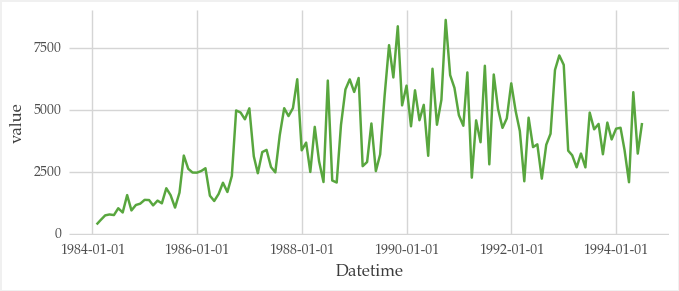

<ggplot: (8782673423586)>

In [4]:
import plotnine as p9

time_plot = p9.ggplot(data=series) + \
            p9.aes(x='ds', y='y') + \
            MY_THEME + \
            p9.geom_line(color='#58a63e', size=1) + \
            p9.labs(x='Datetime', y='value')


time_plot + p9.theme(figure_size=(8,3))

## Decomposed time plot

/opt/miniconda3/envs/common/lib/python3.9/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/miniconda3/envs/common/lib/python3.9/site-packages/plotnine/facets/strips.py:216: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/opt/miniconda3/envs/common/lib/python3.9/site-packages/plotnine/facets/strips.py:216: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/opt/miniconda3/envs/common/lib/python3.9/site-

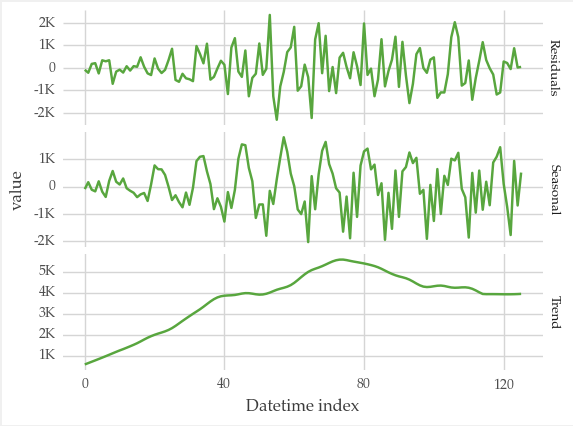

<ggplot: (8782673040568)>

In [5]:
import pandas as pd
from numerize import numerize
from statsmodels.tsa.seasonal import STL

ts_decomp = STL(series['y'], period=12).fit()

components = {
    'Trend': ts_decomp.trend,
    'Seasonal': ts_decomp.seasonal,
    'Residuals': ts_decomp.resid,
}

components_df = pd.DataFrame(components).reset_index()
melted_data = components_df.melt('index')

labs = lambda lst: [numerize.numerize(x) for x in lst]

decomposed_timeplot = \
    p9.ggplot(melted_data) + \
    p9.aes(x='index', y='value') + \
    p9.facet_grid('variable ~.', scales='free') + \
    MY_THEME + \
    p9.geom_line(color='#58a63e', size=1) + \
    p9.labs(x='Datetime index') + \
    p9.scale_y_continuous(labels=labs)


decomposed_timeplot

## Lag plot

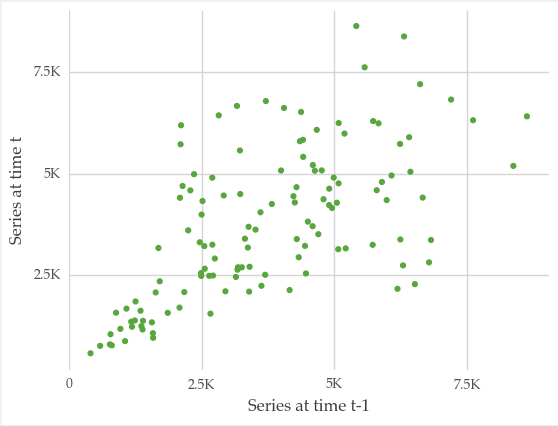

<ggplot: (8782673277480)>

In [6]:
X = [series['y'].shift(i) for i in list(range(2, 0, -1))]
X = pd.concat(X, axis=1).dropna()
X.columns = ['t-1', 't']

lag_plot = p9.ggplot(X) + \
           p9.aes(x='t-1', y='t') + \
           MY_THEME + \
           p9.geom_point(color='#58a63e') + \
           p9.labs(x='Series at time t-1',
                   y='Series at time t') + \
           p9.scale_y_continuous(labels=labs) + \
           p9.scale_x_continuous(labels=labs)

lag_plot

## Auto-correlation plot

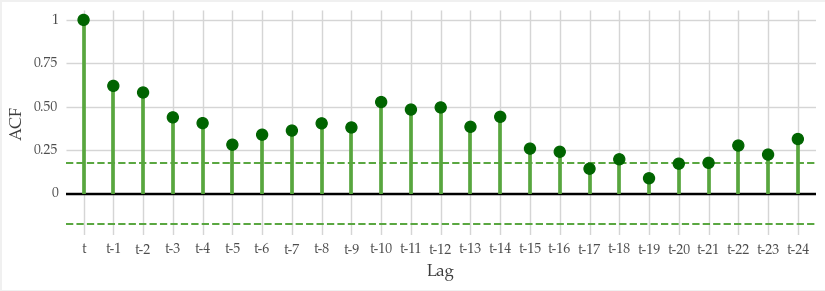

<ggplot: (8782673022106)>

In [7]:
import numpy as np
from statsmodels.tsa.stattools import acf

acf_x = acf(
    series['y'],
    nlags=24,
    alpha=0.05,
    bartlett_confint=True
)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame({
    'ACF': acf_vals,
    'ACF_low': acf_conf_int[:, 0],
    'ACF_high': acf_conf_int[:, 1],
})

acf_df['Lag'] = ['t'] + [f't-{i}' for i in range(1, 25)]
acf_df['Lag'] = pd.Categorical(acf_df['Lag'], categories=acf_df['Lag'])

significance_thr = 2 / np.sqrt(len(series['y']))

acf_plot = p9.ggplot(acf_df, p9.aes(x='Lag', y='ACF')) + \
           p9.geom_hline(yintercept=significance_thr,
                         linetype='dashed',
                         color='#58a63e',
                         size=.8) + \
           p9.geom_hline(yintercept=-significance_thr,
                         linetype='dashed',
                         color='#58a63e',
                         size=.8) + \
           p9.geom_hline(yintercept=0, linetype='solid', color='black', size=1) + \
           p9.geom_segment(p9.aes(x='Lag',
                                  xend='Lag',
                                  y=0, yend='ACF'),
                           size=1.5,
                           color='#58a63e'
                           ) + \
           p9.geom_point(size=4, color='darkgreen', ) + \
           MY_THEME

acf_plot + p9.theme(figure_size=(10,3))

## Seasonal line plot

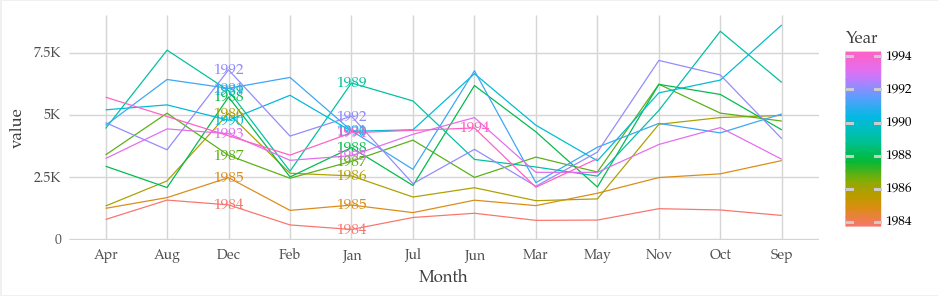

<ggplot: (8782672534974)>

In [8]:

COLOR_LIST = [
    '#F8766D', '#D39200', '#93AA00', '#00BA38', '#00C19F',
    '#00B9E3', '#619CFF', '#DB72FB', '#FF61C3'
]

index = series.set_index(['ds']).index

series['Year'] = index.year
series['Month'] = [x[:3] for x in index.month_name()]

data_labs = series.groupby('Year').apply(lambda x: x.iloc[[0, -1], :])

seasonal_line_plot = \
    p9.ggplot(series) + \
    p9.aes(x='Month',
           y='y',
           group='Year',
           color='Year') + \
    MY_THEME + \
    p9.scale_color_gradientn(colors=COLOR_LIST) + \
    p9.geom_line() + \
    p9.geom_text(data=data_labs,
                 mapping=p9.aes(label='Year')) + \
    p9.scale_y_continuous(labels=labs) + \
    p9.labs(y='value')


seasonal_line_plot + p9.theme(figure_size=(10,3))

## Seasonal sub-series plot

/opt/miniconda3/envs/common/lib/python3.9/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/miniconda3/envs/common/lib/python3.9/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/miniconda3/envs/common/lib/python3.9/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/miniconda3/envs/common/lib/python3.9/site-pac

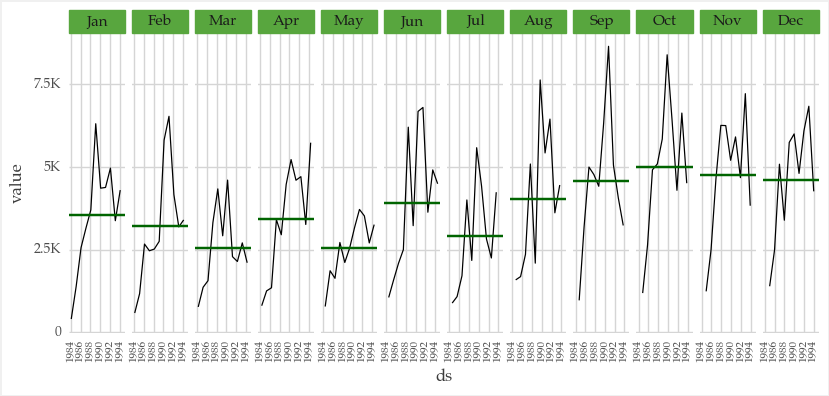

<ggplot: (8782641462956)>

In [9]:
grouped_df = series.groupby('Month')['y']
group_avg = grouped_df.mean()
group_avg = group_avg.reset_index()
series['Month'] = pd.Categorical(series['Month'], 
                                 categories=series['Month'].unique())
group_avg['Month'] = pd.Categorical(group_avg['Month'], 
                                    categories=series['Month'].unique())

seas_subseries_plot = \
    p9.ggplot(series) + \
    p9.aes(x='ds',
           y='y') + \
    MY_THEME + \
    p9.theme(axis_text_x=p9.element_text(size=8, angle=90),
             legend_title=p9.element_blank(),
             strip_background_x=p9.element_text(color='#58a63e'),
             strip_text_x=p9.element_text(size=11)) + \
    p9.geom_line() + \
    p9.facet_grid('. ~Month') + \
    p9.geom_hline(data=group_avg,
                  mapping=p9.aes(yintercept='y'),
                  colour='darkgreen',
                  size=1) + \
    p9.scale_y_continuous(labels=labs) + \
    p9.scale_x_datetime(breaks=date_breaks('2 years'), 
                        labels=date_format('%Y')) + \
    p9.labs(y='value')

seas_subseries_plot + p9.theme(figure_size=(10,4))

## Bi-boxplot

/var/folders/5v/2cdqb1qd0vdbjj_br05_3_vr0000gn/T/ipykernel_45478/3799997179.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


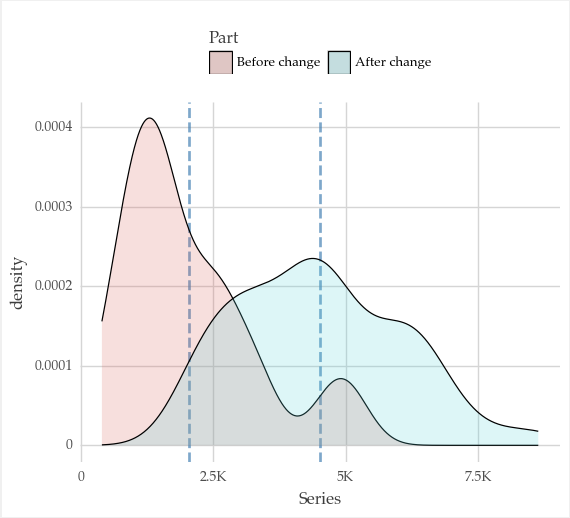

<ggplot: (8782641883374)>

In [12]:
change_index = 40
before, after = train_test_split(series, train_size=change_index, shuffle=False)

n_bf, n_af = before.shape[0], after.shape[0]

p1_df = pd.DataFrame({'Series': before['y'], 'Id': range(n_bf)})
p1_df['Part'] = 'Before change'
p2_df = pd.DataFrame({'Series': after['y'], 'Id': range(n_af)})
p2_df['Part'] = 'After change'

df = pd.concat([p1_df, p2_df])
df['Part'] = pd.Categorical(df['Part'], categories=['Before change', 'After change'])

group_avg = df.groupby('Part').mean()['Series']

density_plot = \
    p9.ggplot(df) + \
    p9.aes(x='Series', fill='Part') + \
    MY_THEME + \
    p9.theme(legend_position='top') + \
    p9.geom_vline(xintercept=group_avg,
                  linetype='dashed',
                  color='steelblue',
                  size=1.1,
                  alpha=0.7) + \
    p9.geom_density(alpha=.2) + \
    p9.scale_x_continuous(labels=labs)

density_plot